In [16]:
from spreg import OLS, vif, OLS_Regimes
import pysal as ps
import libpysal
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from tobler.area_weighted import area_join, area_interpolate
from pysal.explore import esda
import contextily
from sklearn.preprocessing import RobustScaler
from esda.moran import Moran, Moran_Local
import matplotlib as mpl

In [2]:
# Load regression gds 

selected = gpd.read_file('../YouthInTheCity/data/regression_gdf.shp')

# Select features manually

selected['extra_edu']=selected.loc[:,'education']

selected.drop(columns=['schools', 'universiti', 'kindergart','HK_EU15', 'HK_EU28', 'HK_Polen', 'HK_EheJug', 'HK_EheSU', 'HK_Turk',
              'schools', 'universiti','kindergart','night_life',
                       'mig_rate','HK_Arab', 'HK_Sonst', 'HK_NZOrd', 'BZR_NAME', 
              'noise',  'health_car', 'vegpm10', 'change','ch_rate',
            'public_tra', 'green' ,'other_sch', 'secon_sch','vocat_sch',
                'sp_nee_sch', 'community','night_life', 'water',  'ave_rent',
              'public_ser','dyn_ew', 'dyn_unempl', 'priv_schoo', 'primary_sc',
                        'five_y_pls', 'dyn_sales','air', 'education','eating','bio'], inplace=True)

# Export it as shapefile
selected.to_file('../raw_data/infra_model_gdf.shp', mode="w")

# Load it again
selected = gpd.read_file('../raw_data/infra_model_gdf.shp')

In [3]:
selected

,PLR_ID,culture,outdoor_fa,outdoor_le,social_hou,public_hou,child_pov,vegpm20,Gymnasium,kita,stations,extra_edu,geometry
0,11501341,2.0,224.0,8.0,1.302637,24.830919,2.58,3.456812,0.0,20.0,10.0,1.0,"POLYGON ((399848.954 5815619.506, 399854.727 5..."
1,3701659,12.0,130.0,10.0,0.390507,12.771489,8.13,2.896211,1.0,47.0,13.0,6.0,"POLYGON ((393175.012 5821135.577, 393167.174 5..."
2,7601340,1.0,4.0,6.0,12.720000,26.730000,41.68,2.648765,0.0,17.0,0.0,0.0,"POLYGON ((388394.110 5807792.070, 388379.276 5..."
3,2500831,7.0,221.0,14.0,0.740000,8.370000,21.15,2.706697,2.0,41.0,13.0,2.0,"POLYGON ((396010.552 5819339.570, 396021.567 5..."
4,12601134,0.0,85.0,24.0,1.560000,42.230000,51.53,3.861459,1.0,24.0,2.0,1.0,"POLYGON ((387367.428 5828619.763, 387315.862 5..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
531,12500927,0.0,61.0,9.0,1.560000,42.230000,20.69,5.223326,2.0,27.0,4.0,0.0,"POLYGON ((387280.650 5828614.114, 387266.882 5..."
532,3200204,0.0,75.0,8.0,3.209599,3.458242,4.24,3.389884,0.0,7.0,2.0,0.0,"POLYGON ((392586.179 5829994.574, 392586.626 5..."
533,10400941,1.0,45.0,4.0,0.550044,0.751582,2.89,2.551829,0.0,12.0,12.0,0.0,"POLYGON ((406064.851 5815581.891, 406061.455 5..."
534,8100101,18.0,342.0,1.0,6.729473,9.548275,40.42,6.286957,1.0,47.0,3.0,2.0,"POLYGON ((391887.140 5816592.598, 391898.686 5..."


In [4]:
# loading dbf
db = libpysal.io.open('../raw_data/infra_model_gdf.dbf','r')

# computing spatial weights
queen = libpysal.weights.Queen.from_dataframe(selected)
inv_dist = libpysal.weights.DistanceBand.from_dataframe(selected, 5000, geom_col='geometry', binary=False)
rook = libpysal.weights.Rook.from_dataframe(selected)

In [5]:
corr = selected.corr()
corr_df = corr.unstack().reset_index() #Unstack correlation matrix
corr_df.columns = ["feature_1", "feature_2", "correlation"] #Rename the columns
corr_df.sort_values(by="correlation", ascending=False, inplace=True)
corr_df = corr_df[corr_df["feature_1"] != corr_df["feature_2"]] #remove the self-corr
corr_df.head(20)

,feature_1,feature_2,correlation
21,culture,kita,0.631574
109,kita,culture,0.631574
119,kita,extra_edu,0.585532
141,extra_edu,kita,0.585532
14,culture,outdoor_fa,0.447399
25,outdoor_fa,culture,0.447399
122,stations,outdoor_fa,0.421796
34,outdoor_fa,stations,0.421796
23,culture,extra_edu,0.401098
133,extra_edu,culture,0.401098


In [6]:
y = np.array(selected['child_pov'])
X = selected.drop(columns=[
    'PLR_ID','child_pov', 'geometry']).to_numpy()

In [7]:
columns = [
        'culture', 'outdoor_fa', 'outdoor_le', 'social_hou',
        'public_hou', 'vegpm20', 'Gymnasium', 'kita', 'stations',
        'extra_edu'
]

In [8]:
m1 = OLS(y,
        X,
        w=inv_dist,
        name_y='child_pov',
        name_x=columns,
        name_w='dist',
        name_ds='basic_model',
        white_test=True,
        gwk=inv_dist,
        spat_diag=True,
        moran=True)

(array([ 14.,  58.,  92., 126., 109.,  90.,  31.,   7.,   3.,   6.]),
 array([ 0.8236552 ,  6.9010344 , 12.97841361, 19.05579281, 25.13317202,
        31.21055122, 37.28793043, 43.36530964, 49.44268884, 55.52006805,
        61.59744725]),
 <BarContainer object of 10 artists>)

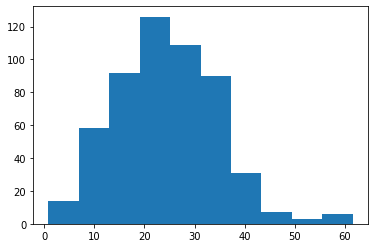

In [9]:
plt.hist(m1.predy.flatten())

<AxesSubplot:>

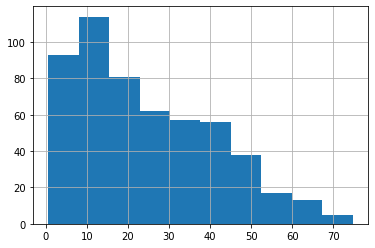

In [81]:
selected['child_pov'].hist()

In [50]:
mae(selected['child_pov'], m1.predy.flatten())

10.502076260567264

In [51]:
mse(selected['child_pov'], m1.predy)

177.50079323920716

In [52]:
np.sqrt(mse(selected['child_pov'], m1.predy.flatten()))

13.322942364177935

In [10]:
print(m1.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            : basic_model
Weights matrix      :        dist
Dependent Variable  :   child_pov                Number of Observations:         536
Mean dependent var  :     24.5406                Number of Variables   :          11
S.D. dependent var  :     16.6701                Degrees of Freedom    :         525
R-squared           :      0.3601
Adjusted R-squared  :      0.3479
Sum squared residual:   95140.425                F-statistic           :     29.5401
Sigma-square        :     181.220                Prob(F-statistic)     :   4.571e-45
S.E. of regression  :      13.462                Log likelihood        :   -2148.516
Sigma-square ML     :     177.501                Akaike info criterion :    4319.033
S.E of regression ML:     13.3229                Schwarz criterion     :    4366.158

-----------------------------------------------------------------------------

In [145]:
# creating vif dataframe

v = vif(m1)
del(v[0])
vif_array = np.array(v, dtype=float)

v_d = pd.DataFrame({'feature': columns, 
                   'vif': vif_array[:,0], 
                   'tolerance':  vif_array[:,1]})

v_d

,feature,vif,tolerance
0,culture,2.046572,0.488622
1,outdoor_fa,1.605890,0.622708
2,outdoor_le,1.205693,0.829398
3,social_hou,1.266336,0.789680
4,public_hou,1.309245,0.763799
5,vegpm20,1.131491,0.883790
6,Gymnasium,1.216399,0.822098
7,kita,2.456212,0.407131
8,stations,1.653586,0.604746
9,extra_edu,1.710570,0.584601


In [83]:
mae(selected.child_pov, m1.predy)

10.502076260567264

In [84]:
mse(selected.child_pov, m1.predy)

177.50079323920716

In [59]:
selected.iloc[127]

PLR_ID                                                  9501838
culture                                                     0.0
outdoor_fa                                                123.0
outdoor_le                                                  3.0
social_hou                                             0.950683
public_hou                                            15.204921
child_pov                                                  7.96
vegpm20                                               12.072736
Gymnasium                                                   0.0
kita                                                        9.0
stations                                                   18.0
extra_edu                                                   0.0
geometry      POLYGON ((413177.503 5810392.1, 413221.925 581...
Name: 127, dtype: object

In [11]:
# Adding a resituals column to sample dataframe
res = selected[['PLR_ID', 'geometry']]
res['residuals'] = m1.u

# plotting residuals - red = underestimation, blue = overestimation
#res.plot('residuals', figsize=(15,10), cmap= 'seismic', legend=True)

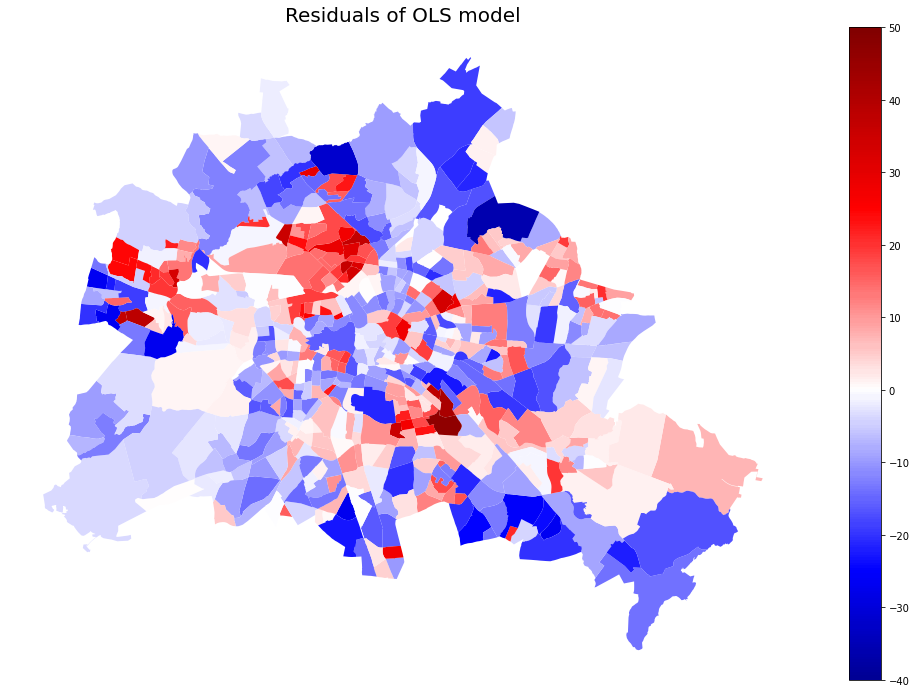

In [19]:
class MidpointNormalize(mpl.colors.Normalize):
    def __init__(self, vmin, vmax, midpoint=0, clip=False):
        self.midpoint = midpoint
        mpl.colors.Normalize.__init__(self, vmin, vmax, clip)
    def __call__(self, value, clip=None):
        normalized_min = max(0, 1 / 2 * (1 - abs((self.midpoint - self.vmin) / (self.midpoint - self.vmax))))
        normalized_max = min(1, 1 / 2 * (1 + abs((self.vmax - self.midpoint) / (self.midpoint - self.vmin))))
        normalized_mid = 0.5
        x, y = [self.vmin, self.midpoint, self.vmax], [normalized_min, normalized_mid, normalized_max]
        return np.ma.masked_array(np.interp(value, x, y))
#here goes residuals column
vals = res.residuals
vmin = -40
vmax = 50
norm = MidpointNormalize(vmin=vmin, vmax=vmax, midpoint=0)
ax = res.plot(figsize = (18,12), column='residuals', cmap='seismic', norm=norm, legend=True)
ax.axis('off')
ax.set_title('Residuals of OLS model', fontsize=20)
plt.savefig(fname='plots/ols_residuals.png',transparent=False, bbox_inches="tight", facecolor='white')
plt.show()

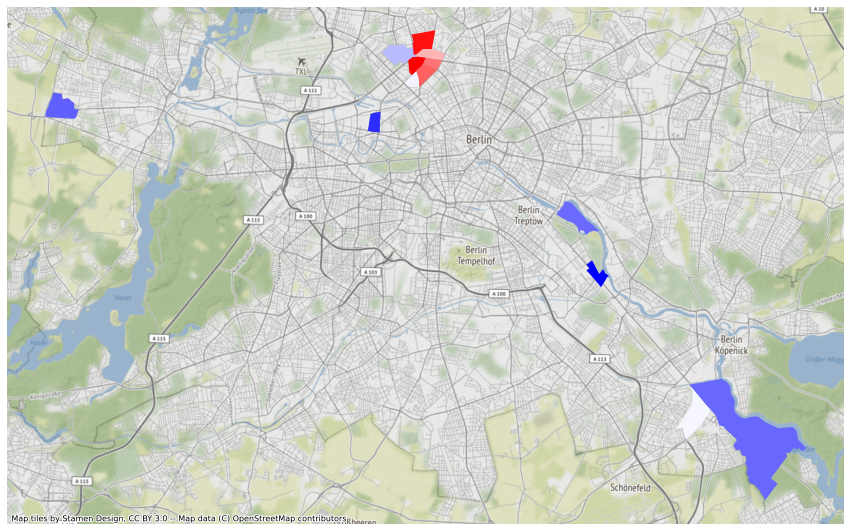

In [154]:
# instantiating knn
knn = libpysal.weights.KNN.from_dataframe(selected, k=5)
# Row standardise weights
knn.transform = "R"
# Run LISA on residuals
outliers = esda.moran.Moran_Local(m1.u, knn, permutations=9999)
# Select only LISA cluster cores
error_clusters = outliers.q % 2 == 1
# Filter out non-significant clusters
error_clusters &= outliers.p_sim <= 0.001
# Add `error_clusters` and `local_I` columns
ax = (
    selected.assign(
        error_clusters=error_clusters,
        local_I=outliers.Is
        # Retain error clusters only
    )
    .query(
        "error_clusters"
        # Sort by I value to largest plot on top
    )
    .sort_values(
        "local_I"
        # Plot I values
    )
    .plot("local_I", cmap="bwr", marker=".", figsize=(15,10))
)
# Add basemap
contextily.add_basemap(ax, crs=selected.crs)
# Remove axes
ax.set_axis_off();

In [156]:
selected

,PLR_ID,culture,outdoor_fa,outdoor_le,social_hou,public_hou,child_pov,vegpm20,Gymnasium,kita,stations,extra_edu,geometry,residuals,east,residuals_m2
0,11501341,2.0,224.0,8.0,1.302637,24.830919,2.58,3.456812,0.0,20.0,10.0,1.0,"POLYGON ((399848.954 5815619.506, 399854.727 5...",-19.688017,1,-19.952260
1,3701659,12.0,130.0,10.0,0.390507,12.771489,8.13,2.896211,1.0,47.0,13.0,6.0,"POLYGON ((393175.012 5821135.577, 393167.174 5...",-3.633546,1,-2.960949
2,7601340,1.0,4.0,6.0,12.720000,26.730000,41.68,2.648765,0.0,17.0,0.0,0.0,"POLYGON ((388394.110 5807792.070, 388379.276 5...",0.435593,0,5.296694
3,2500831,7.0,221.0,14.0,0.740000,8.370000,21.15,2.706697,2.0,41.0,13.0,2.0,"POLYGON ((396010.552 5819339.570, 396021.567 5...",6.981902,1,6.869233
4,12601134,0.0,85.0,24.0,1.560000,42.230000,51.53,3.861459,1.0,24.0,2.0,1.0,"POLYGON ((387367.428 5828619.763, 387315.862 5...",17.408565,1,18.474703
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
531,12500927,0.0,61.0,9.0,1.560000,42.230000,20.69,5.223326,2.0,27.0,4.0,0.0,"POLYGON ((387280.650 5828614.114, 387266.882 5...",-14.019090,0,-14.254279
532,3200204,0.0,75.0,8.0,3.209599,3.458242,4.24,3.389884,0.0,7.0,2.0,0.0,"POLYGON ((392586.179 5829994.574, 392586.626 5...",-9.762495,1,-10.797044
533,10400941,1.0,45.0,4.0,0.550044,0.751582,2.89,2.551829,0.0,12.0,12.0,0.0,"POLYGON ((406064.851 5815581.891, 406061.455 5...",-2.560691,1,-3.615019
534,8100101,18.0,342.0,1.0,6.729473,9.548275,40.42,6.286957,1.0,47.0,3.0,2.0,"POLYGON ((391887.140 5816592.598, 391898.686 5...",9.063653,1,5.842273


In [63]:
# loading east/west maps
west = gpd.read_file('../raw_data/more_maps/Ortsteile__Berlin_West_EPSG54030.shp')
east = gpd.read_file('../raw_data/more_maps/Ortsteile__Berlin_Ost_EPSG54030.shp')

# adapting projections
east.to_crs(crs='EPSG:25833', inplace=True)
west.to_crs(crs='EPSG:25833', inplace=True)

# dissolving
west = west.dissolve()
east = east.dissolve()

# merging both maps into an eastwest geodataframe
eastwest = east.append(west)

# adding an east column to eastwest geodataframe
eastwest['east'] = eastwest.OBJECTID.map({1:1,
                                             2:0})

eastwest = eastwest[['east','geometry']]

# merging eastwest geodataframe with sample df

selected_east = selected.sjoin_nearest(
    eastwest, how='left').dissolve(
    by='PLR_ID')

selected = selected.merge(selected_east.reset_index()[['PLR_ID','east']], on='PLR_ID')

In [138]:
X.shape

(536, 10)

In [64]:
# Running an OLS Regimes model

m2 = OLS_Regimes(y,
                X,
                w=inv_dist,
                regimes=selected['east'],
                name_y='child_pov',
                name_x=columns,
                name_w='dist',
                name_ds='basic_model',
                white_test=True,
                spat_diag=True,
                moran=True)

In [158]:
print(m2.summary)

REGRESSION
----------

SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES ESTIMATION - REGIME 0
---------------------------------------------------------------
Data set            : basic_model
Weights matrix      :        dist
Dependent Variable  : 0_child_pov                Number of Observations:         195
Mean dependent var  :     21.2256                Number of Variables   :          11
S.D. dependent var  :     15.2800                Degrees of Freedom    :         184
R-squared           :      0.3605
Adjusted R-squared  :      0.3257
Sum squared residual:   28966.751                F-statistic           :     10.3717
Sigma-square        :     157.428                Prob(F-statistic)     :   8.339e-14
S.E. of regression  :      12.547                Log likelihood        :    -764.281
Sigma-square ML     :     148.547                Akaike info criterion :    1550.562
S.E of regression ML:     12.1880                Schwarz criterion     :    1586.565

--------------------------------

In [65]:
# Adding a resituals column to sample dataframe
res['residuals_m2'] = m2.u

# plotting residuals - red = underestimation, blue = overestimation
#res.plot('residuals_m2', figsize=(15,10), cmap= 'seismic', legend=True)

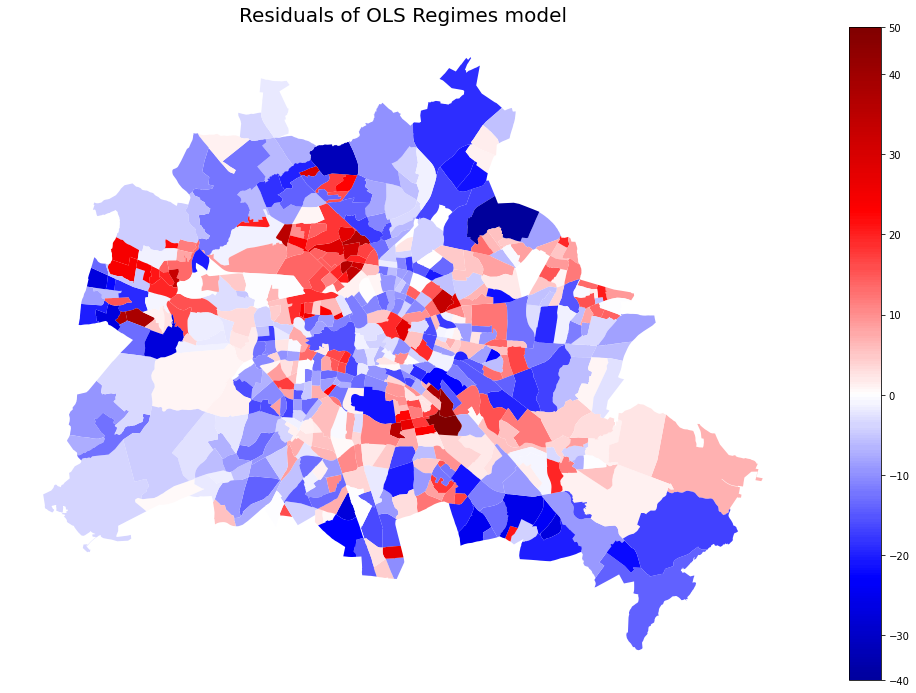

In [72]:
#here goes residuals column
vals = res.residuals_m2
vmin = min(res.residuals_m2)
vmax = max(res.residuals_m2)
norm = MidpointNormalize(vmin=vmin, vmax=vmax, midpoint=0)
ax = res.plot(figsize = (18,12), column='residuals', cmap='seismic', norm=norm, legend=True)
ax.axis('off')
ax.set_title('Residuals of OLS Regimes model', fontsize=20)
#plt.savefig(fname='plots/ols_residuals.svg',transparent=False, bbox_inches="tight")
plt.show()

In [66]:
mae(selected.child_pov, m2.predy)

10.201795823385401

In [67]:
mse(selected.child_pov, m2.predy)

172.27784757756328